<a href="https://colab.research.google.com/github/gulabpatel/CNN_and_TransferLearning/blob/master/13_Human_emotions_Detections_images_and_videos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification of emotions

## Importing the libraries

In [ ]:
!pip install face_detector

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import face_detector
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization

## Loading the images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Dataset/ferEmotionsImg.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

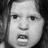

In [ ]:
tf.keras.preprocessing.image.load_img('/content/images/train/angry/10002.jpg')

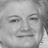

In [ ]:
image = tf.keras.preprocessing.image.load_img('/content/images/train/happy/100.jpg')
image

### Train and test set

In [ ]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)
train_dataset = training_generator.flow_from_directory('/content/images/train',
                                                        target_size = (48, 48),
                                                        batch_size = 16,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

Found 28821 images belonging to 7 classes.


In [ ]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
np.unique(train_dataset.classes, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3993,  436, 4103, 7164, 4982, 4938, 3205]))

In [ ]:
train_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

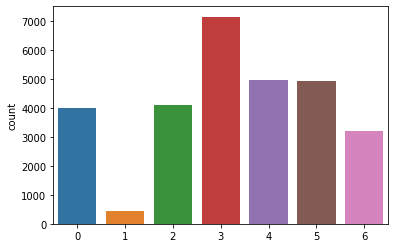

In [ ]:
sns.countplot(x = train_dataset.classes);

In [ ]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/images/validation',
                                                  target_size = (48, 48),
                                                  batch_size = 1,
                                                  class_mode = 'categorical',
                                                  shuffle = False)

Found 7066 images belonging to 7 classes.


## Building and training the convolutional neural network

In [ ]:
2*2*2*32

256

In [ ]:
# Based on: https://github.com/rajeevratan84/DeepLearningCV/blob/master/18.2%20Building%20an%20Emotion%20Detector%20with%20LittleVGG.ipynb
# Padding: https://www.pico.net/kb/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-tensorflow
# BatchNormalization: https://keras.io/api/layers/normalization_layers/batch_normalization/
# Dropout: https://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
num_detectors = 32
num_classes = 7
width, height = 48, 48
epochs = 70

network = Sequential()

network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same', input_shape = (width, height, 3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors, (3,3), activation='relu', padding = 'same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2 * num_detectors, activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes, activation='softmax'))
print(network.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network.fit(train_dataset, epochs=15)

Epoch 1/15
1802/1802 [==============================] - 55s 31ms/step - loss: 1.2780 - accuracy: 0.5188
Epoch 2/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.2346 - accuracy: 0.5352
Epoch 3/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.1988 - accuracy: 0.5516
Epoch 4/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.1719 - accuracy: 0.5644
Epoch 5/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.1370 - accuracy: 0.5762
Epoch 6/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.1216 - accuracy: 0.5866
Epoch 7/15
1802/1802 [==============================] - 57s 31ms/step - loss: 1.0996 - accuracy: 0.5924
Epoch 8/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.0750 - accuracy: 0.6017
Epoch 9/15
1802/1802 [==============================] - 56s 31ms/step - loss: 1.0615 - accuracy: 0.6075
Epoch 10/15
1802/1802 [==============================] - 56s 31m

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights_emotions.hdf5')

In [ ]:
with open('/content/network_emotions.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "conv2d_input"}}, {"class_name": "Conv2D", "config": {"name": "conv2d", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 48, 48, 3], "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "BatchNormalization", "config": {"name": "batch_normalization", "trainable": true, "dtype": "float32", "axis": [3], "momentum": 0.99, "epsilon": 0.001, "c

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('/content/weights_emotions.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                        

## Evaluating the neural network

In [ ]:
network_loaded.evaluate(test_dataset)

7066/7066 [==============================] - 44s 6ms/step - loss: 0.9366 - accuracy: 0.6550


[0.9365736842155457, 0.6549674272537231]

In [ ]:
predictions = network_loaded.predict(test_dataset)
predictions

7066/7066 [==============================] - 33s 5ms/step


array([[6.9514728e-01, 8.2750125e-03, 6.8451479e-02, ..., 8.9669488e-02,
        1.2182969e-01, 1.3090405e-03],
       [4.4978976e-02, 3.4447477e-04, 2.7249622e-01, ..., 1.5999788e-01,
        5.0626427e-01, 2.2762888e-03],
       [8.0857748e-01, 4.3537360e-02, 3.0338513e-02, ..., 3.9730795e-02,
        7.6452665e-02, 3.7055524e-04],
       ...,
       [1.3544832e-02, 2.2454745e-04, 2.9407624e-02, ..., 1.3942190e-02,
        5.6556975e-03, 9.2990851e-01],
       [1.7489119e-02, 1.5370401e-03, 4.1896764e-02, ..., 1.5934169e-02,
        1.2251082e-02, 6.6342041e-02],
       [1.5157331e-02, 9.2147046e-04, 4.7122691e-02, ..., 4.1319281e-03,
        1.7029964e-03, 6.6680539e-01]], dtype=float32)

In [ ]:
predictions = np.argmax(predictions, axis = 1)
predictions

array([0, 5, 0, ..., 6, 3, 6])

In [ ]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.6549674497594112

In [ ]:
test_dataset.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
cm

array([[ 578,    8,   36,   40,  144,  134,   20],
       [  44,   44,    3,    1,    5,   10,    4],
       [ 166,    3,  282,   49,  134,  263,  121],
       [  37,    0,   15, 1596,   87,   52,   38],
       [  85,    1,   14,   89,  843,  160,   24],
       [ 132,    1,   51,   39,  239,  659,   18],
       [  29,    1,   53,   41,   34,   13,  626]])

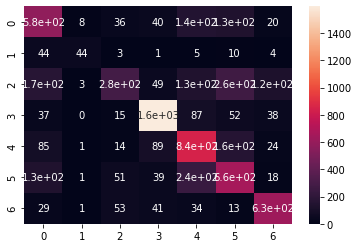

In [ ]:
sns.heatmap(cm, annot=True);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.54      0.60      0.57       960
           1       0.76      0.40      0.52       111
           2       0.62      0.28      0.38      1018
           3       0.86      0.87      0.87      1825
           4       0.57      0.69      0.62      1216
           5       0.51      0.58      0.54      1139
           6       0.74      0.79      0.76       797

    accuracy                           0.65      7066
   macro avg       0.66      0.60      0.61      7066
weighted avg       0.66      0.65      0.65      7066



## Classifying multiple images

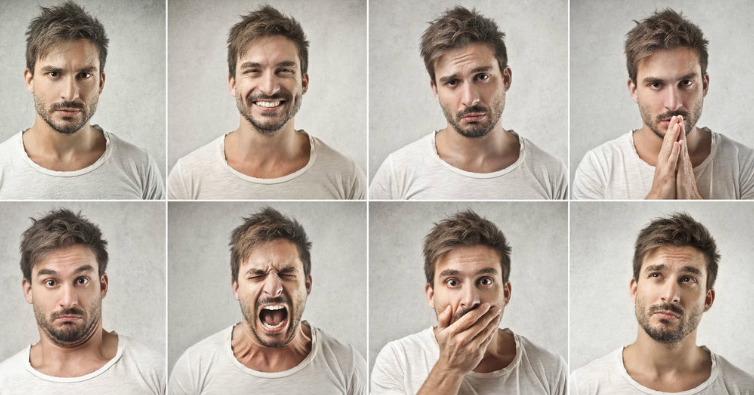

In [ ]:
image = cv2.imread('/content/face_emotions.png')
cv2_imshow(image)

In [ ]:
cascPath = 'haarcascade_frontalface_default.xml'
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades +cascPath)

In [ ]:
faces = face_detector.detectMultiScale(image)
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

In [ ]:
test_dataset.class_indices.keys()

dict_keys(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

In [ ]:
emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 [==============================] - 0s 29ms/step


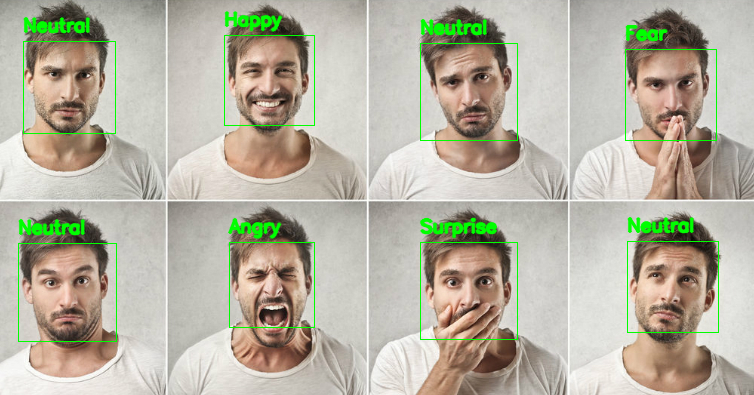

In [ ]:
for (x, y, w, h) in faces:
  cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 1)
  roi = image[y:y + h, x:x + w]
  #cv2_imshow(roi)
  roi = cv2.resize(roi, (48, 48))
  #cv2_imshow(roi)
  roi = roi / 255
  roi = np.expand_dims(roi, axis = 0)
  #print(roi.shape)
  prediction = network_loaded.predict(roi)
  #print(prediction)
  cv2.putText(image, emotions[np.argmax(prediction)], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2, cv2.LINE_AA)
cv2_imshow(image)

## Classifying emotions in videos

In [ ]:
cap = cv2.VideoCapture('/content/drive/MyDrive/emotion_test01.mp4')
connected, video = cap.read()
print(connected, video.shape)

In [ ]:
# fourcc.org
save_path = '/content/drive/MyDrive/Videos/emotion_test01_result.avi'
fourcc = cv2.VideoWriter_fourcc(*'XVID')
fps = 24
output_video = cv2.VideoWriter(save_path, fourcc, fps, (video.shape[1], video.shape[0]))

In [ ]:
while (cv2.waitKey(1) < 0):
  connected, frame = cap.read()
  if not connected:
    break
  faces = face_detector.detectMultiScale(frame, scaleFactor=1.2, minNeighbors=5, minSize=(30,30))
  if len(faces) > 0:
    for (x, y, w, h) in faces:
      frame = cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
      roi = frame[y:y + h, x:x + w]
      roi = cv2.resize(roi, (48, 48))
      roi = roi / 255
      roi = np.expand_dims(roi, axis = 0)
      prediction = network_loaded.predict(roi)

      if prediction is not None:
        result = np.argmax(prediction)
        cv2.putText(frame, emotions[result], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)
  
  cv2_imshow(frame)
  output_video.write(frame)

print('End')
output_video.release()
cv2.destroyAllWindows()